In [1]:
import random
import math
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import nrrd

import os
import PIL
import SimpleITK as sitk
import torch
from PIL import Image, ImageOps
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset


from main_ibot import DataAugmentationiBOT

In [2]:
class PETCTDataset3D(Dataset):
    def __init__(self, image_folder, csv_path, mode, transform=None, batch_size=None):
        self.image_folder = image_folder
        dataframe = pd.read_csv(csv_path)
        self.transform = transform
        self.type = mode
        assert mode in ["ct","pet","chest_ct"],'Mode must be "ct","pet" or "chest_ct".'
        self.dataframe_mode=dataframe[dataframe[f"{mode}_segmentation"]==True]
        self.batch_size = batch_size

    def __len__(self):
        return len(self.dataframe_mode)

    def __getitem__(self, idx):
        file_data=self.dataframe_mode.iloc[idx]
        img_path = os.path.join(self.image_folder,file_data["patient_id"],self.type,file_data[f"{self.type}_img_name"])
        image, _ = nrrd.read(img_path)
        
        if self.batch_size:
            image = self.process_img(image)
        image = torch.tensor(image,dtype=torch.float32).unsqueeze(0) #[C,H,W,D]
        image = image.permute(3, 0, 1, 2)        #[D,C,H,W]
        print(image.type())
        if self.transform:
            image = self.transform(image)
        return image

    def process_img(self, img):
        _, _ , D= img.shape
        if D < self.batch_size:
            padding_needed = self.batch_size - D
            img = np.pad(img, ((0, 0), (0, 0), (0, padding_needed)), mode='constant')
        else:
            crop_size = (D - self.batch_size) // 2
            img = img[:, :, crop_size:crop_size+self.batch_size]
        return img




In [3]:
transform = DataAugmentationiBOT(
        (0.4, 1.0),
        (0.05, 0.4),
        2,
        10,
    )
dataset=PETCTDataset3D("../../../shared_data/NSCLC_Radiogenomics/images", 
                       "../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv", 
                       "ct", 
                       transform=None, 
                       batch_size=224)

In [74]:
type_="ct"
image_folder="../../../shared_data/NSCLC_Radiogenomics/images"
dataframe = pd.read_csv("../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv")
dataframe_mode=dataframe[dataframe[f"{type_}_segmentation"]==True]

for idx in range(len(dataframe_mode)):
    file_data=dataframe_mode.iloc[idx]
    img_path = os.path.join(image_folder,file_data["patient_id"],type_,file_data[f"{type_}_img_name"])
    mask_path = os.path.join(image_folder,file_data["patient_id"],type_,file_data[f"{type_}_seg_name"])
    image, _ = nrrd.read(img_path)
    mask, _ = nrrd.read(mask_path)
    image_norm=apply_window_ct(image, width=1800, level=40)
    #msk_img=mask*image_norm
    print(file_data["patient_id"],np.shape(image),np.shape(mask))
    print(img_path,mask_path)
    bb=image_norm[mask>0]
    print(np.shape(bb),np.mean(bb),np.min(bb),np.max(bb))#,np.max(aa[i]))

R01-017 (512, 512, 171) (512, 512, 171)
../../../shared_data/NSCLC_Radiogenomics/images/R01-017/ct/R01-017_ct_image.nrrd ../../../shared_data/NSCLC_Radiogenomics/images/R01-017/ct/R01-017_ct_segmentation.nrrd
(374,) 0.23441325014854425 0.09555555555555556 0.4166666666666667
AMC-041 (512, 512, 263) (512, 512, 263)
../../../shared_data/NSCLC_Radiogenomics/images/AMC-041/ct/AMC-041_ct_image.nrrd ../../../shared_data/NSCLC_Radiogenomics/images/AMC-041/ct/AMC-041_ct_segmentation.nrrd
(175,) 0.23940634920634923 0.09333333333333334 0.405
(2095,) 0.4067223548130469 0.07611111111111112 0.5116666666666667
R01-116 (512, 512, 249) (512, 512, 249)
../../../shared_data/NSCLC_Radiogenomics/images/R01-116/ct/R01-116_ct_image.nrrd ../../../shared_data/NSCLC_Radiogenomics/images/R01-116/ct/R01-116_ct_segmentation.nrrd
(179,) 0.4606269397889509 0.34833333333333333 0.5383333333333333
R01-145 (512, 512, 299) (512, 512, 299)
../../../shared_data/NSCLC_Radiogenomics/images/R01-145/ct/R01-145_ct_image.nrrd ..

IndexError: boolean index did not match indexed array along dimension 2; dimension is 514 but corresponding boolean dimension is 542

In [119]:
mean=[]
std=[]
type_="ct"
image_folder="../../../shared_data/NSCLC_Radiogenomics/images"
dataframe = pd.read_csv("../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv")
dataframe_mode=dataframe[dataframe[f"{type_}_segmentation"]==True]

for idx in tqdm(range(len(dataframe_mode))):
    file_data=dataframe_mode.iloc[idx]
    img_path = os.path.join(image_folder,file_data["patient_id"],type_,file_data[f"{type_}_img_name"])
    image, _ = nrrd.read(img_path)
    image_norm=apply_window_ct(image, width=1800, level=40)
    mean.append(np.mean(image_norm))
    std.append(np.std(image_norm))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [05:23<00:00,  1.69s/it]


In [125]:
np.mean(std)

0.20636193613452872

In [63]:
xx=np.array([[0,0,0],[0,1,0],[0,1,0],[1,1,1],])
yy=np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
np.where(xx**yy>0)

(array([1, 2, 3, 3, 3]), array([1, 1, 0, 1, 2]))

In [66]:
xd=xx*yy
dx=xd[xd>0]
dx

array([ 5,  8, 10, 11, 12])

In [52]:
dataframe_mode

,patient_id,ct_segmentation,ct_seg_name,ct_image,ct_img_name,chest_ct_segmentation,chest_ct_seg_name,chest_ct_image,chest_ct_img_name,pet_segmentation,pet_seg_name,pet_image,pet_img_name
0,R01-069,True,R01-069_ct_segmentation.nrrd,True,R01-069_ct_image.nrrd,True,R01-069_chest_ct_segmentation.dcm,True,R01-069_chest_ct_image.nrrd,True,R01-069_pet_segmentation.nrrd,True,R01-069_pet_image.nrrd
1,R01-012,True,R01-012_ct_segmentation.nrrd,True,R01-012_ct_image.nrrd,True,R01-012_chest_ct_segmentation.dcm,True,R01-012_chest_ct_image.nrrd,True,R01-012_pet_segmentation.nrrd,True,R01-012_pet_image.nrrd
2,R01-117,True,R01-117_ct_segmentation.nrrd,True,R01-117_ct_image.nrrd,True,R01-117_chest_ct_segmentation.dcm,True,R01-117_chest_ct_image.nrrd,True,R01-117_pet_segmentation.nrrd,True,R01-117_pet_image.nrrd
3,R01-161,True,R01-161_ct_segmentation.nrrd,True,R01-161_ct_image.nrrd,False,NaN,False,NaN,True,R01-161_pet_segmentation.nrrd,True,R01-161_pet_image.nrrd
4,R01-118,True,R01-118_ct_segmentation.nrrd,True,R01-118_ct_image.nrrd,True,R01-118_chest_ct_segmentation.dcm,True,R01-118_chest_ct_image.nrrd,True,R01-118_pet_segmentation.nrrd,True,R01-118_pet_image.nrrd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,R01-071,True,R01-071_ct_segmentation.nrrd,True,R01-071_ct_image.nrrd,True,R01-071_chest_ct_segmentation.dcm,True,R01-071_chest_ct_image.nrrd,True,R01-071_pet_segmentation.nrrd,True,R01-071_pet_image.nrrd
203,R01-102,True,R01-102_ct_segmentation.nrrd,True,R01-102_ct_image.nrrd,True,R01-102_chest_ct_segmentation.nrrd,True,R01-102_chest_ct_image.nrrd,True,R01-102_pet_segmentation.nrrd,True,R01-102_pet_image.nrrd
204,R01-100,True,R01-100_ct_segmentation.nrrd,True,R01-100_ct_image.nrrd,True,R01-100_chest_ct_segmentation.nrrd,True,R01-100_chest_ct_image.nrrd,True,R01-100_pet_segmentation.nrrd,True,R01-100_pet_image.nrrd
205,R01-146,True,R01-146_ct_segmentation.nrrd,True,R01-146_ct_image.nrrd,True,R01-146_chest_ct_segmentation.dcm,True,R01-146_chest_ct_image.nrrd,True,R01-146_pet_segmentation.nrrd,True,R01-146_pet_image.nrrd


In [4]:
ls ../../../shared_data/NSCLC_Radiogenomics

images/  info_dataset.csv*  Liver_ROI/  npy/


In [38]:
aa=dataset[10]

torch.FloatTensor


In [34]:
np.sum(np.array(aa[0]))

4129224.0

In [58]:
def windowing_ct(width, level):
    lower_bound = level - width/2
    upper_bound = level + width/2
    return lower_bound, upper_bound

In [57]:
def apply_window_ct(ct, width, level):
    """ Normalize CT image using a window in the HU scale

    Args:
        ct (np.array): ct image.
        width (int): window width in the HU scale.
        level (int): center of the windows in the HU scale.

    Returns:
        ct (np.array): Normalized image in a range 0-1.

    """
    ct_min_val, ct_max_val = windowing_ct(width, level)
    ct_range = ct_max_val - ct_min_val
    ct = (ct - ct_min_val) / ct_range
    ct = np.clip(ct, 0, 1)
    return ct

In [50]:
for i in range(len(aa)):
    bb=apply_window_ct(np.array(aa[i]), width=1800, level=40)
    print(np.shape(bb),np.min(bb),np.max(bb))#,np.max(aa[i]))

-0.23143393 -1.2016667 1.3538889
(1, 512, 512) 0.0 1.0
-0.23022088 -1.2016667 1.3238889
(1, 512, 512) 0.0 1.0
-0.23064972 -1.2016667 1.3238889
(1, 512, 512) 0.0 1.0
-0.23315333 -1.2016667 1.3311111
(1, 512, 512) 0.0 1.0
-0.23527771 -1.2016667 1.3316667
(1, 512, 512) 0.0 1.0
-0.23564623 -1.2016667 1.3305556
(1, 512, 512) 0.0 1.0
-0.23551123 -1.2016667 1.3116666
(1, 512, 512) 0.0 1.0
-0.23541752 -1.2016667 1.32
(1, 512, 512) 0.0 1.0
-0.23520719 -1.2016667 1.3216667
(1, 512, 512) 0.0 1.0
-0.2352373 -1.2016667 1.3288889
(1, 512, 512) 0.0 1.0
-0.23552513 -1.2016667 1.2977778
(1, 512, 512) 0.0 1.0
-0.23600642 -1.2016667 1.3016666
(1, 512, 512) 0.0 1.0
-0.23649988 -1.2016667 1.3005556
(1, 512, 512) 0.0 1.0
-0.23668294 -1.2016667 1.33
(1, 512, 512) 0.0 1.0
-0.23710264 -1.2016667 1.3288889
(1, 512, 512) 0.0 1.0
-0.23746648 -1.2016667 1.3038889
(1, 512, 512) 0.0 1.0
-0.23781294 -1.2016667 1.2677778
(1, 512, 512) 0.0 1.0
-0.23802972 -1.2016667 1.2711111
(1, 512, 512) 0.0 1.0
-0.23818675 -1.201666

In [ ]:
print(np.shape(aa),np.min(aa),np.max(aa))

In [50]:
for i in range(len(aa)):
    print(np.shape(aa[i]))

torch.Size([1, 224, 224, 224])
torch.Size([1, 224, 224, 224])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])
torch.Size([1, 224, 96, 96])


torch.Size([1, 224, 224, 224])
torch.Size([1, 224, 224, 224]) 6.780609 -0.5202599


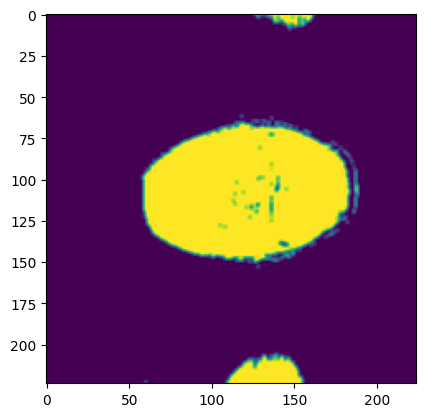

In [55]:
import matplotlib.pyplot as plt
bb=aa[0]
print(np.shape(bb))
test=np.array(bb[0,220,:,:])
print(np.shape(bb),np.max(test),np.min(test))
plt.imshow(test)

In [70]:
class PETCTFolderMask3D(PETCTDataset3D):
    def __init__(self, *args, patch_size, pred_ratio, pred_ratio_var, pred_aspect_ratio,
                 pred_shape='block', pred_start_epoch=0, **kwargs):
        super(PETCTFolderMask3D, self).__init__(*args, **kwargs)
        self.psz = patch_size
        self.pred_ratio = pred_ratio[0] if isinstance(pred_ratio, list) and \
            len(pred_ratio) == 1 else pred_ratio
        self.pred_ratio_var = pred_ratio_var[0] if isinstance(pred_ratio_var, list) and \
            len(pred_ratio_var) == 1 else pred_ratio_var
        if isinstance(self.pred_ratio, list) and not isinstance(self.pred_ratio_var, list):
            self.pred_ratio_var = [self.pred_ratio_var] * len(self.pred_ratio)
        self.log_aspect_ratio = tuple(map(lambda x: math.log(x), pred_aspect_ratio))
        self.pred_shape = pred_shape
        self.pred_start_epoch = pred_start_epoch

    def get_pred_ratio(self):
        if hasattr(self, 'epoch') and self.epoch < self.pred_start_epoch:
            return 0

        if isinstance(self.pred_ratio, list):
            pred_ratio = []
            for prm, prv in zip(self.pred_ratio, self.pred_ratio_var):
                assert prm >= prv
                pr = random.uniform(prm - prv, prm + prv) if prv > 0 else prm
                pred_ratio.append(pr)
            pred_ratio = random.choice(pred_ratio)
        else:
            assert self.pred_ratio >= self.pred_ratio_var
            pred_ratio = random.uniform(self.pred_ratio - self.pred_ratio_var, self.pred_ratio + \
                self.pred_ratio_var) if self.pred_ratio_var > 0 else self.pred_ratio

        return pred_ratio

    def set_epoch(self, epoch):
        self.epoch = epoch

    def __getitem__(self, index):
        output = super(PETCTFolderMask3D, self).__getitem__(index)

        masks = []
        for img in output:
            try:
                D, H, W = math.ceil(img.shape[-3] / self.psz), img.shape[-2] // self.psz, img.shape[-1] // self.psz
            except:
                # skip non-image
                continue

            high = self.get_pred_ratio() * H * W

            if self.pred_shape == 'block':
                # following BEiT (https://arxiv.org/abs/2106.08254), see at
                # https://github.com/microsoft/unilm/blob/b94ec76c36f02fb2b0bf0dcb0b8554a2185173cd/beit/masking_generator.py#L55
                mask = np.zeros((D, H, W), dtype=bool)
                mask_count = 0
                while mask_count < high:
                    max_mask_patches = high - mask_count

                    delta = 0
                    for attempt in range(10):
                        low = (min(H, W) // 3) ** 2 
                        target_area = random.uniform(low, max_mask_patches)
                        aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio))
                        h = int(round(math.sqrt(target_area * aspect_ratio)))
                        w = int(round(math.sqrt(target_area / aspect_ratio)))
                        if w < W and h < H:
                            top = random.randint(0, H - h)
                            left = random.randint(0, W - w)

                            num_masked = mask[:, top: top + h, left: left + w].sum()
                            if 0 < h * w - num_masked <= max_mask_patches:
                                for i in range(top, top + h):
                                    for j in range(left, left + w):
                                        if not mask[:, i, j].any():
                                            mask[:, i, j] = 1
                                            delta += 1

                        if delta > 0:
                            break

                    if delta == 0:
                        break
                    else:
                        mask_count += delta

            elif self.pred_shape == 'rand':
                mask = np.hstack([
                    np.zeros(H * W - int(high)),
                    np.ones(int(high)),
                ]).astype(bool)
                np.random.shuffle(mask)
                mask = mask.reshape(H, W)
                mask = np.tile(mask, (D, 1, 1))
            else:
                # no implementation
                assert False

            masks.append(mask)

        return (output, masks)

In [71]:
data_path="../../../shared_data/NSCLC_Radiogenomics/images"
csv_path="../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv"
mode="pet"
transform = DataAugmentationiBOT(
        (0.4, 1.0),
        (0.05, 0.4),
        2,
        10,
    )
pred_size = 4*8 
pred_ratio=[0.0, 0.3]
pred_ratio_var=[0.0,0.2]
pred_aspect_ratio=(0.3, 1/0.3)
pred_shape='rand'
pred_start_epoch=50
batch_size=224

dataset = PETCTFolderMask3D(
            data_path,
            csv_path, 
            mode,
            transform=transform,
            patch_size=pred_size,
            pred_ratio=pred_ratio,
            pred_ratio_var=pred_ratio_var,
            pred_aspect_ratio=pred_aspect_ratio,
            pred_shape=pred_shape,
            pred_start_epoch=pred_start_epoch,
            batch_size=batch_size)

In [73]:
aa=dataset[3]

torch.FloatTensor


In [84]:
aa[1][0]

array([[[False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False,  True, False, False,  True, False,  True],
        [False, False, False,  True, False,  True, False],
        [ True, False,  True, False,  True,  True,  True],
        [ True,  True, False, False, False, False,  True],
        [ True, False, False,  True,  True,  True,  True]],

       [[False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False,  True, False, False,  True, False,  True],
        [False, False, False,  True, False,  True, False],
        [ True, False,  True, False,  True,  True,  True],
        [ True,  True, False, False, False, False,  True],
        [ True, False, False,  True,  True,  True,  True]],

       [[False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False,  True, False, False,  True, False,  

In [66]:
ls ../../../shared_data/NSCLC_Radiogenomics

images/  info_dataset.csv*  Liver_ROI/  npy/


In [88]:
save_dict = {
            'student': 1,
            'teacher': 2,
            'optimizer': 3,
            'epoch': 4,
            'args': 5,
            'ibot_loss': 6,
        }

log_stats = {**{f'train_{k}': v for k, v in save_dict.items()},
                     'epoch': 1}

In [89]:
log_stats

{'train_student': 1,
 'train_teacher': 2,
 'train_optimizer': 3,
 'train_epoch': 4,
 'train_args': 5,
 'train_ibot_loss': 6,
 'epoch': 1}

In [113]:
image=np.ones((512,512,35))*0.5
print(np.shape(image))
image = torch.tensor(image,dtype=torch.float32).unsqueeze(0) #[C,H,W,D]
image = image.permute(3, 0, 1, 2)        #[D,C,H,W]

transform = transforms.ColorJitter(
    brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)

# apply the above transform on image
output_img = transform(image)

# display result
#print(np.max(output_img),np.min(output_img))
np.array(output_img)


(512, 512, 35)


array([[[[0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         ...,
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163]]],


       [[[0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         ...,
         [0.5064163, 0.5064163, 0.5064163, ..., 0.5064163, 0.5064163,
          0.5064163],
         [0.5064163, 0.5064163, 0.5064163, ..., 

In [103]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Read the image from computer
#print(np.shape(np.ones((20,20))*0,7))
input_img = Image.fromarray(np.uint8(np.ones((256,256))*255))
print(np.max(input_img),np.min(input_img/255))
# define a transform
transform = transforms.ColorJitter(
    brightness=0.04, contrast=0.04, saturation=0.02, hue=0.01)

# apply the above transform on image
output_img = transform(input_img)

# display result
print(np.max(output_img),np.min(output_img))
np.array(output_img)


TypeError: unsupported operand type(s) for /: 'Image' and 'int'

In [6]:
ls ../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv

images/  info_dataset.csv*  Liver_ROI/  npy/


In [ ]:
final size=4, 8192]

In [ ]:
main_ibot.py --arch swin3D --batch_size_per_gpu 2 --epochs 400 --data_path ../../../shared_data/NSCLC_Radiogenomics/images --csv_path ../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv --mode ct --saveckp_freq 40 --clip_grad 3.0 --global_crops_scale 0.4 1.0 --local_crops_scale 0.05 0.4 --lr 0.0005 --min_lr 1e-06 --norm_last_layer False --patch_size 4 --pred_ratio 0.0 0.3 --pred_ratio_var 0.0 0.2 --pred_shape block --pred_start_epoch 50 --warmup_teacher_temp_epochs 30 --window_size 7 --output_dir ../output_1line


In [10]:
from monai.networks.blocks import MLPBlock as Mlp
mlp = Mlp(hidden_size=256,mlp_dim=256, act="GELU", dropout_rate=0, dropout_mode="swin")

In [11]:
mlp

MLPBlock(
  (linear1): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (fn): GELU(approximate='none')
  (drop1): Dropout(p=0, inplace=False)
  (drop2): Dropout(p=0, inplace=False)
)

In [40]:
import numpy as np
import torch
test_inp=torch.Tensor(np.ones((2,1024,48)))
#np.shape(mlp(test_inp))

In [27]:
from monai.networks.layers import get_act_layer
import torch.nn as nn
from monai.utils import look_up_option

SUPPORTED_DROPOUT_MODE = {"vit", "swin", "vista3d"}


class MLPBlockSwin(nn.Module):
    """
    A multi-layer perceptron block, based on: "Dosovitskiy et al.,
    An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>"
    """

    def __init__(
        self, input_dim: int, hidden_size: int, dropout_rate: float = 0.0, act: tuple | str = "GELU", dropout_mode="vit"
    ) -> None:
        """
        Args:
            hidden_size: dimension of hidden layer.
            input_dim: dimension of input layer.
            mlp_dim: dimension of feedforward layer. If 0, `hidden_size` will be used.
            dropout_rate: fraction of the input units to drop.
            act: activation type and arguments. Defaults to GELU. Also supports "GEGLU" and others.
            dropout_mode: dropout mode, can be "vit" or "swin".
                "vit" mode uses two dropout instances as implemented in
                https://github.com/google-research/vision_transformer/blob/main/vit_jax/models.py#L87
                "swin" corresponds to one instance as implemented in
                https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_mlp.py#L23
                "vista3d" mode does not use dropout.

        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise ValueError("dropout_rate should be between 0 and 1.")
        self.linear1 = nn.Linear(input_dim, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.fn = get_act_layer(act)
        # Use Union[nn.Dropout, nn.Identity] for type annotations
        self.drop1: Union[nn.Dropout, nn.Identity]
        self.drop2: Union[nn.Dropout, nn.Identity]

        dropout_opt = look_up_option(dropout_mode, SUPPORTED_DROPOUT_MODE)
        if dropout_opt == "vit":
            self.drop1 = nn.Dropout(dropout_rate)
            self.drop2 = nn.Dropout(dropout_rate)
        elif dropout_opt == "swin":
            self.drop1 = nn.Dropout(dropout_rate)
            self.drop2 = self.drop1
        elif dropout_opt == "vista3d":
            self.drop1 = nn.Identity()
            self.drop2 = nn.Identity()
        else:
            raise ValueError(f"dropout_mode should be one of {SUPPORTED_DROPOUT_MODE}")

    def forward(self, x):
        x = self.fn(self.linear1(x))
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        return x

In [41]:
MLP=MLPBlockSwin(48,256)
MLP

MLPBlockSwin(
  (linear1): Linear(in_features=48, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (fn): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (drop2): Dropout(p=0.0, inplace=False)
)

In [42]:
np.shape(MLP(test_inp))

torch.Size([2, 1024, 256])

# DATASET

In [2]:
import random
import math
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import nrrd
import utils

import os
import PIL
import SimpleITK as sitk
import torch
from PIL import Image, ImageOps
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset

In [3]:
class PETCTDataset3D(Dataset):
    def __init__(self, image_folder, csv_path, mode, transform=None, batch_size=None):
        self.image_folder = image_folder
        dataframe = pd.read_csv(csv_path)
        self.transform = transform
        self.type = mode
        assert mode in ["ct","pet","chest_ct"],'Mode must be "ct","pet" or "chest_ct".'
        self.dataframe_mode=dataframe[dataframe[f"{mode}_segmentation"]==True]
        self.batch_size = batch_size

    def __len__(self):
        return len(self.dataframe_mode)

    def __getitem__(self, idx):
        file_data=self.dataframe_mode.iloc[idx]
        img_path = os.path.join(self.image_folder,file_data["patient_id"],self.type,file_data[f"{self.type}_img_name"])
        image, _ = nrrd.read(img_path)
        if self.type=="ct":
            image = utils.apply_window_ct(image, width=1800, level=40)
        else:
            image = image/file_data["pet_mean"]
        if self.batch_size:
            image = self.process_img(image)
        image = torch.tensor(image,dtype=torch.float32).unsqueeze(0) #[C,H,W,D]
        image = image.permute(3, 0, 1, 2)        #[D,C,H,W]
        if self.transform:
            image = self.transform(image)
        return image, file_data["patient_id"]

    def process_img(self, img):
        _, _ , D= img.shape
        if D < self.batch_size:
            padding_needed = self.batch_size - D
            img = np.pad(img, ((0, 0), (0, 0), (0, padding_needed)), mode='constant')
        else:
            crop_size = (D - self.batch_size) // 2
            img = img[:, :, crop_size:crop_size+self.batch_size]
        return img

In [83]:
from pathlib import Path
import torchvision.transforms as T
from torchvision.ops.misc import Permute
from torchvision import models as torchvision_models
from tensorboardX import SummaryWriter
from models.head import iBOTHead
from loader import CTFolderMask, PETCTFolderMask3D, HistoricalDocFolderMask
from models.swin3D import swin_3D
from models.vit_lora import vit_lora

class DataAugmentationiBOT(object):
    def __init__(self, global_crops_scale, local_crops_scale, global_crops_number, local_crops_number,mode,bcsh):
        flip_and_color_jitter = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply(
                [T.ColorJitter(brightness=bcsh[0], contrast=bcsh[1], saturation=bcsh[2], hue=bcsh[3])],
                p=0.8
            ),
            # T.RandomGrayscale(p=0.2),
        ]) 
        #normalize = T.Normalize(mean=[0.07126], std=[0.13697])
        if mode=="ct":
            normalize = T.Normalize(mean=[0.1218], std=[0.2063]) #CT
        else:
            normalize = T.Normalize(mean=[0.066], std=[0.3504]) #PET
        permute = Permute([1, 0, 2, 3]) #[D,C,H,W] --> [C,D,H,W]
        # normalize = T.Compose([
        #     T.ToTensor(),
        #     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        # ])

        self.global_crops_number = global_crops_number
        # transformation for the first global crop
        self.global_transfo1 = T.Compose([
            T.RandomResizedCrop(256, scale=global_crops_scale, interpolation=3), #128 224
            flip_and_color_jitter,
            #T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.)),
            permute,
            normalize,
        ])
        """
        # transformation for the rest of global crops
        self.global_transfo2 = T.Compose([
            T.RandomResizedCrop(256, scale=global_crops_scale, interpolation=3),
            flip_and_color_jitter,
            T.RandomApply(
                [T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.))],
                p=0.1
            ),
            T.RandomSolarize(threshold=0.5, p=0.2),
            permute,
            normalize,
        ])
        # transformation for the local crops
        self.local_crops_number = local_crops_number
        self.local_transfo = T.Compose([
            T.RandomResizedCrop(96, scale=local_crops_scale, interpolation=3),
            flip_and_color_jitter,
            T.RandomApply(
                [T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.))],
                p=0.5
            ),
            permute,
            normalize
        ])
        """
    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        """
        for _ in range(self.global_crops_number - 1):
            crops.append(self.global_transfo2(image))
            
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        """
        return crops


In [ ]:
brightness=[0.1,0.2,0.4,0.7,0.8]
contrast=[0.1,0.2,0.4,0.7,0.8]
saturation=[0.1,0.2,0.4,0.7,0.8]
hue=[0.1,0.2,0.4,0.7,0.8]
dict_info_all=[]
image_folder="../../../shared_data/NSCLC_Radiogenomics/images"
csv_path="../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv"

for mode in ["ct","pet"]:
    for bb in brightness:
        for cc in contrast:
            for ss in saturation:
                for hh in hue:
                    transform = DataAugmentationiBOT(
                        [0.4,1.0],
                        [0.05,0.4],
                        2,
                        10,
                        mode,
                        [bb,cc,ss,hh]
                    )
                    dataset=PETCTDataset3D(image_folder, csv_path, mode, transform=transform, batch_size=256)
                    name_all=[]
                    mean_all=[]
                    name_all=[]
                    median_all=[]
                    var_all=[]
                    std_all=[]
                    max_all=[]
                    min_all=[]
                    for ind in range(2):
                        for i in range(len(dataset)):
                            data,name=dataset[i]
                            data=np.array(data)[0,0]
                            mean=np.mean(data)
                            median=np.median(data)
                            var=np.var(data)
                            std=np.std(data)
                            mx=np.max(data)
                            mn=np.min(data)
                        
                            name_all.append(name)
                            mean_all.append(mean)
                            median_all.append(median)
                            var_all.append(var)
                            std_all.append(std)
                            max_all.append(mx)
                            min_all.append(mn)
                        dict_info={}
                        dict_info["mode"]=mode
                        dict_info["bcsh"]=[bb,cc,ss,hh]
                        dict_info["results"]={"names":name_all,"mean":mean_all,"median":median_all,"var":var_all,"std":std_all,"max":max_all,"min":min_all}
                        dict_info_all.append(dict_info)

np.save("mods_dataset.npy",dict_info_all)


In [32]:
image_folder="../../../shared_data/NSCLC_Radiogenomics/images"
csv_path="../../../shared_data/NSCLC_Radiogenomics/info_dataset.csv"
mode="ct"
dataset=PETCTDataset3D(image_folder, csv_path, mode, transform=transform, batch_size=256)

In [52]:
name_all=[]
mean_all=[]
name_all=[]
median_all=[]
var_all=[]
std_all=[]
max_all=[]
min_all=[]
for i in range(len(dataset)):
    data,name=dataset[i]
    data=np.array(data)[0,0]
    mean=np.mean(data)
    median=np.median(data)
    var=np.var(data)
    std=np.std(data)
    mx=np.max(data)
    mn=np.min(data)

    name_all.append(name)
    mean_all.append(mean)
    median_all.append(median)
    var_all.append(var)
    std_all.append(std)
    max_all.append(mx)
    min_all.append(mn)

In [53]:
dict_info={}
dict_info["mode"]="ct"
dict_info["bcsh"]=None
dict_info["results"]={"names":name_all,"mean":mean_all,"median":median_all,"var":var_all,"std":std_all,"max":max_all,"min":min_all}


In [70]:
np.save("normal_date.npy",[dict_info])

In [72]:
xdd=np.load("normal_date.npy",allow_pickle=True)

In [76]:
len(xdd[0]["results"]["names"])

192

In [40]:
dict_info={}
dict_info["mode"]=mode
dict_info["bcsh"]=[bb,cc,ss,hh]
dict_info["results"]={"names":name_all,"mean":mean_all,"median":median_all,"var":var_all,"std":std_all,"max":max_all,"min":min_all}


[]

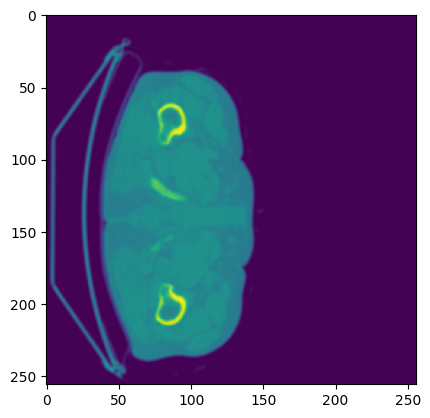

In [25]:
plt.imshow(dataset[0][0][0][0][24])